In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [79]:
path = '/home/himanshu/dl/dataset/cityscape/'
def get_filenames(path):
    img_list = list()
    mask_list = list()
    for filename in os.listdir(os.path.join(path, 'image_edited')):
        img_list.append(os.path.join(path, 'image_edited', filename))
        mask_list.append(os.path.join(path, 'mask_edited', filename[: -15]) + 'gtCoarse_color.png')
    return img_list, mask_list

In [80]:
img_list, mask_list = get_filenames(path)
# mask_list = get_filenames(os.path.join(path, 'mask_edited'))
print(img_list[2])
print(mask_list[2])

/home/himanshu/dl/dataset/cityscape/image_edited/wurzburg_000000_001383_leftImg8bit.png
/home/himanshu/dl/dataset/cityscape/mask_edited/wurzburg_000000_001383_gtCoarse_color.png


(844, 2029, 3)


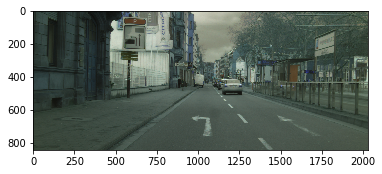

In [94]:
img = cv2.imread(img_list[776])
print(img.shape)
plt.imshow(img)
plt.show()
# print(img_list[2][49:-15] + 'gtCoarse_color.png')

(803, 2029)
[  0 255]


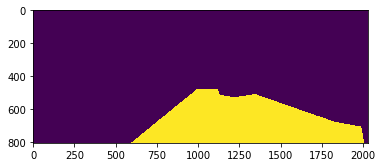

In [109]:
img = cv2.imread(mask_list[776], cv2.IMREAD_GRAYSCALE)
print(img.shape)
print(np.unique(img))
plt.imshow(img)
plt.show()

In [2]:
class CityscapesDataset(data.Dataset) :
    def __init__(self, root = '/home/himanshu/dl/dataset/cityscape/', transform = None) :
        self.img_list, self.mask_list = CityscapesDataset.get_filenames(root)
        # label for road is 255
        self.valid_labels = [255]
        self.ignore_index = 250
        self.transform = transform
        
    def __getitem__(self, idx) :
        img = cv2.imread(self.img_list[idx])
        img = cv2.resize(img, (2028, 802))
        mask = cv2.imread(self.mask_list[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (2028, 802))
        mask = self.encode_segmap(mask)
        
        if self.transform :
            img = self.transform(img)
            assert(img.shape == (3, 802, 2028))
        else :
            assert(img.shape == (802, 2028, 3))
        assert(mask.shape == (802, 2028))
        return img, mask
    
    def __len__(self) :
        return len(self.img_list)
    
    def encode_segmap(self, mask) :
        mask[mask != 0] = 1
        return mask
    
    @staticmethod
    def get_filenames(path) :
        img_list = list()
        mask_list = list()
        for filename in os.listdir(os.path.join(path, 'image_edited')):
            img_list.append(os.path.join(path, 'image_edited', filename))
            mask_list.append(os.path.join(path, 'mask_edited', filename[: -15]) + 'gtCoarse_color.png')
        return img_list, mask_list
    
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [3]:
mean = [0.28689554, 0.32513303, 0.28389177]
std = [0.18696375, 0.19017339, 0.18720214]
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean = mean, std = std)
            ])
dataset = CityscapesDataset(transform = transform)

In [4]:
dataloader = data.DataLoader(dataset, batch_size = 2, shuffle = True)

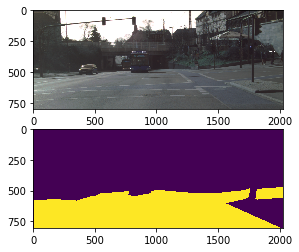

[0 1]


In [5]:
unorm = UnNormalize(mean = mean, std = std)
img, mask = next(iter(dataloader))
# print(mask[0])
fig = plt.figure()
plt.subplot(2, 1, 1)
img2 = unorm(img)
img2 = img2.transpose(1, 2).transpose(2, 3).detach().cpu().numpy()
plt.imshow(img2[1])
plt.subplot(2, 1, 2)
plt.imshow(mask[1])
plt.show()
print(np.unique(mask.numpy()))

In [7]:
from models.enet.model import *
net = ENet(num_classes = 1)
net = net.cuda()
out = net(img.cuda())
print(out.shape)

torch.Size([2, 1, 802, 2028])


In [8]:
out2 = out.squeeze(1)
print(out2.shape)

torch.Size([2, 802, 2028])


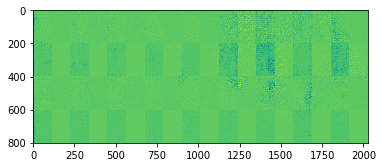

In [9]:
plt.imshow(out2[1].detach().cpu().numpy())

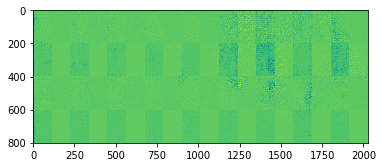

In [10]:
out2 = out.transpose(0, 1)
plt.imshow(out2[0][1].detach().cpu().numpy())